# tsfreshを使って特徴量を生成するサンプル

## tsfreshのインストール
pipを使って最新のtsfreshをインストールします。

In [1]:
!pip install -U tsfresh

## ライブラリのインポート

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsfresh.feature_extraction import (
    MinimalFCParameters,
    extract_features,
    feature_calculators,
)


## データの読み込み

In [3]:
#必須の入出力ファイルのパス
filepath = {
    "train": "/root/dkaggle-user/data/train.csv", #学習データ
    "test": "/root/dkaggle-user/data/test.csv", #テストデータ
    "sample": "/root/dkaggle-user/data/sample.csv", #提出用予測結果のフォーマットのサンプル
    "submission": "submission.csv", #提出用予測結果
}

In [4]:
#データ読み込み(時間かかるので注意)
train_df = pd.read_csv(filepath["train"], encoding="cp932",index_col=0)
test_df = pd.read_csv(filepath["test"], encoding="cp932",index_col=0)
sample = pd.read_csv(filepath["sample"], encoding="utf-8")

In [5]:
#思い思いの分析をしてください

## アイドリング部分の切り出し

ここでは例としてアイドリング部分のエンジン回転数に関する特徴量を生成しますので  
はじめにデータを確認し、簡易的にアイドリング部分を特定していきます。

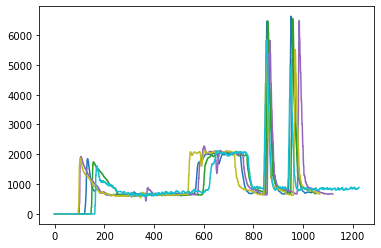

In [6]:
for i in range(10):
    plt.plot(train_df[train_df.id==i]['ｴﾝｼﾞﾝ回転数'].reset_index(drop=True))
plt.show()

t=300から450で切り出すとアイドリング部分が切り出せそうなので、全てのデータの300-450を拡大して確認します。

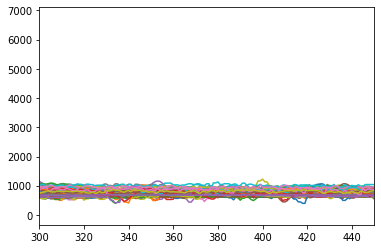

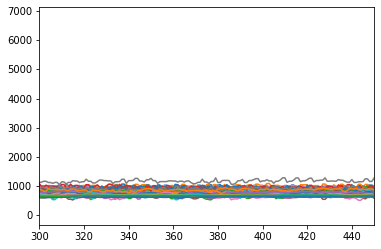

In [7]:
for i in range(len(train_df.id.unique())):
    plt.plot(train_df[train_df.id==i]['ｴﾝｼﾞﾝ回転数'].reset_index(drop=True))
plt.xlim(300,450)
plt.show()

plt.figure()
for i in range(len(test_df.id.unique())):
    plt.plot(test_df[test_df.id==i]['ｴﾝｼﾞﾝ回転数'].reset_index(drop=True))
plt.xlim(300,450)
plt.show()

全てアイドリング状態のようなのでこの部分を切り出します。

In [8]:
train_df_idle = pd.concat(
    [
        train_df.loc[train_df.id == id, ["t", "ｴﾝｼﾞﾝ回転数", "id"]][300:450]
        for id in train_df.id.unique()
    ]
)

test_df_idle = pd.concat(
    [
        test_df.loc[test_df.id == id, ["t", "ｴﾝｼﾞﾝ回転数", "id"]][300:450]
        for id in test_df.id.unique()
    ]
)


## 特徴量の生成

ここからエンジン回転数から特徴量を作ることを考えてみます。  
一例として回転数の平均や標準偏差を特徴量にしたい場合は、例えば以下のようなコードで特徴量を作ることができます。  
（pandasの使い方については[こちら](https://github.com/The-Japan-DataScientist-Society/100knocks-preprocess)が参考になります！）

In [9]:
train_x = train_df_idle.groupby('id')['ｴﾝｼﾞﾝ回転数'].agg(['mean','std']).reset_index(drop=False)
train_x.head()

,id,mean,std
0,0,672.943840,21.547080
1,2,621.453333,11.245633
2,4,654.753333,70.236985
3,8,637.440000,26.112940
4,9,659.520000,33.720669


より多種の特徴量を生成したい場合には自分で関数を作成しなければならず、いろいろな特徴量を試したいと思っても時間がかかってしまいます。  
tsfreshはこのような場合に使用すると便利な関数で、たくさんの特徴量を自動的に生成してくれます。  
実際にtsfreshを使って特徴量を生成してみます。

In [10]:
# train_df_idleに対して、idごとにtの順で特徴量を生成する
features = extract_features(
        train_df_idle,
        column_id="id",
        column_sort="t",
    ).reset_index(drop=True)

Feature Extraction: 100%|██████████| 210/210 [00:18<00:00, 11.19it/s]


In [11]:
features.head()

,ｴﾝｼﾞﾝ回転数__variance_larger_than_standard_deviation,ｴﾝｼﾞﾝ回転数__has_duplicate_max,ｴﾝｼﾞﾝ回転数__has_duplicate_min,ｴﾝｼﾞﾝ回転数__has_duplicate,ｴﾝｼﾞﾝ回転数__sum_values,ｴﾝｼﾞﾝ回転数__abs_energy,ｴﾝｼﾞﾝ回転数__mean_abs_change,ｴﾝｼﾞﾝ回転数__mean_change,ｴﾝｼﾞﾝ回転数__mean_second_derivative_central,ｴﾝｼﾞﾝ回転数__median,...,ｴﾝｼﾞﾝ回転数__permutation_entropy__dimension_6__tau_1,ｴﾝｼﾞﾝ回転数__permutation_entropy__dimension_7__tau_1,ｴﾝｼﾞﾝ回転数__query_similarity_count__query_None__threshold_0.0,"ｴﾝｼﾞﾝ回転数__matrix_profile__feature_""min""__threshold_0.98","ｴﾝｼﾞﾝ回転数__matrix_profile__feature_""max""__threshold_0.98","ｴﾝｼﾞﾝ回転数__matrix_profile__feature_""mean""__threshold_0.98","ｴﾝｼﾞﾝ回転数__matrix_profile__feature_""median""__threshold_0.98","ｴﾝｼﾞﾝ回転数__matrix_profile__feature_""25""__threshold_0.98","ｴﾝｼﾞﾝ回転数__matrix_profile__feature_""75""__threshold_0.98",ｴﾝｼﾞﾝ回転数__mean_n_absolute_max__number_of_maxima_7
0,1.0,1.0,0.0,1.0,100941.575958,6.799719e+07,4.331247,-0.019762,0.012156,673.889967,...,3.865477,4.244276,NaN,0.988674,5.634550,2.497562,2.397392,1.913994,2.896182,727.538399
1,1.0,1.0,1.0,1.0,93218.000000,5.794948e+07,3.657718,0.140940,0.000000,623.000000,...,4.107238,4.540807,NaN,0.836493,3.306735,1.959687,1.802975,1.428338,2.523584,645.000000
2,1.0,1.0,1.0,1.0,98213.000000,6.504034e+07,9.389262,0.167785,0.027027,639.000000,...,3.774696,4.355854,NaN,1.171556,4.909613,2.957620,3.148506,2.575360,3.601332,853.714286
3,1.0,0.0,1.0,1.0,95616.000000,6.105106e+07,6.147651,0.134228,0.013514,638.000000,...,3.751876,4.238095,NaN,0.689013,2.769147,1.659305,1.561821,1.411467,1.961594,705.285714
4,1.0,0.0,0.0,1.0,98928.000000,6.541442e+07,15.724832,0.315436,0.074324,656.000000,...,3.711275,4.231307,NaN,0.856190,3.426321,1.850183,1.664063,1.385601,2.196405,737.571429


In [12]:
len(features.columns)

789

デフォルトでは789個（！）の特徴量が生成されました。  
生成する特徴量は指定することができますが、あらかじめ決められた特徴量のセットを指定することもできます。

In [13]:
settings = MinimalFCParameters()

features = extract_features(
        train_df_idle,
        column_id="id",
        column_sort="t",
        default_fc_parameters=settings,
    ).reset_index(drop=True)

Feature Extraction: 100%|██████████| 210/210 [00:00<00:00, 1630.56it/s]


In [14]:
features.head()

,ｴﾝｼﾞﾝ回転数__sum_values,ｴﾝｼﾞﾝ回転数__median,ｴﾝｼﾞﾝ回転数__mean,ｴﾝｼﾞﾝ回転数__length,ｴﾝｼﾞﾝ回転数__standard_deviation,ｴﾝｼﾞﾝ回転数__variance,ｴﾝｼﾞﾝ回転数__root_mean_square,ｴﾝｼﾞﾝ回転数__maximum,ｴﾝｼﾞﾝ回転数__absolute_maximum,ｴﾝｼﾞﾝ回転数__minimum
0,100941.575958,673.889967,672.943840,150.0,21.475136,461.181474,673.286412,735.0,735.0,570.507463
1,93218.000000,623.000000,621.453333,150.0,11.208084,125.621156,621.554396,652.0,652.0,594.000000
2,98213.000000,639.000000,654.753333,150.0,70.002470,4900.345822,658.484832,882.0,882.0,439.000000
3,95616.000000,638.000000,637.440000,150.0,26.025751,677.339733,637.971076,726.0,726.0,537.000000
4,98928.000000,656.000000,659.520000,150.0,33.608078,1129.502933,660.375752,753.0,753.0,587.000000


In [15]:
len(features.columns)

10

`MinimalFCParameters`では平均や中央値など基本的な特徴量が10個の特徴量が生成されました。 
どの特徴量を生成するかは`default_fc_parameters`に渡される`dict`で定義されており、`MinimalFCParameters`で得られる変数（ここでは`settings`）では以下のような感じになっています。

In [16]:
settings

{'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None}

また、他の特徴量を追加する場合は以下のように`settings`に項目を追加します。どのような特徴量が用意されているかは[公式ドキュメント](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html)を参照ください。

In [17]:
# 4次のARモデルの係数を特徴量として追加する
settings["ar_coefficient"] = [
    {"coeff": 0, "k": 4},
    {"coeff": 1, "k": 4},
    {"coeff": 2, "k": 4},
    {"coeff": 3, "k": 4},
]

features = extract_features(
        train_df_idle,
        column_id="id",
        column_sort="t",
        default_fc_parameters=settings,
    ).reset_index(drop=True)

Feature Extraction: 100%|██████████| 210/210 [00:00<00:00, 264.22it/s]


In [18]:
features.head()

,ｴﾝｼﾞﾝ回転数__sum_values,ｴﾝｼﾞﾝ回転数__median,ｴﾝｼﾞﾝ回転数__mean,ｴﾝｼﾞﾝ回転数__length,ｴﾝｼﾞﾝ回転数__standard_deviation,ｴﾝｼﾞﾝ回転数__variance,ｴﾝｼﾞﾝ回転数__root_mean_square,ｴﾝｼﾞﾝ回転数__maximum,ｴﾝｼﾞﾝ回転数__absolute_maximum,ｴﾝｼﾞﾝ回転数__minimum,ｴﾝｼﾞﾝ回転数__ar_coefficient__coeff_0__k_4,ｴﾝｼﾞﾝ回転数__ar_coefficient__coeff_1__k_4,ｴﾝｼﾞﾝ回転数__ar_coefficient__coeff_2__k_4,ｴﾝｼﾞﾝ回転数__ar_coefficient__coeff_3__k_4
0,100941.575958,673.889967,672.943840,150.0,21.475136,461.181474,673.286412,735.0,735.0,570.507463,69.462391,1.604567,-0.763471,0.124091
1,93218.000000,623.000000,621.453333,150.0,11.208084,125.621156,621.554396,652.0,652.0,594.000000,73.675402,0.733803,0.024843,0.188467
2,98213.000000,639.000000,654.753333,150.0,70.002470,4900.345822,658.484832,882.0,882.0,439.000000,55.916275,1.338971,-0.434648,0.175088
3,95616.000000,638.000000,637.440000,150.0,26.025751,677.339733,637.971076,726.0,726.0,537.000000,92.270675,0.968995,0.172063,-0.371020
4,98928.000000,656.000000,659.520000,150.0,33.608078,1129.502933,660.375752,753.0,753.0,587.000000,196.814321,0.871855,0.241041,-0.583286


さらに4つの特徴量が追加されました。  
このほか、独自の特徴量も生成できますのでその方法は[公式ドキュメント](https://tsfresh.readthedocs.io/en/latest/)や[記事](https://qiita.com/niwashing/items/c5e75c80256ffb2e0dd7)を参照ください。

## 学習
以上のように生成した特徴量で適当に学習モデルを生成し、予測をしてみます。

In [19]:
train_x = features
train_y = train_df.groupby('id').fail_type.min().values

In [20]:
test_x = extract_features(
        test_df_idle,
        column_id="id",
        column_sort="t",
        default_fc_parameters=settings,
    ).reset_index(drop=True)

Feature Extraction: 100%|██████████| 204/204 [00:00<00:00, 263.10it/s]


In [21]:
len(test_x.columns)

14

In [22]:
# 学習データから適当に評価用のデータを分ける（交差検証はしない）
n=-42
x_train = np.array(train_x[:n])
y_train = np.array(train_y[:n])
x_valid = np.array(train_x[n:])
y_valid = np.array(train_y[n:])

パラメータは適当に設定

In [23]:
params = {'lambda_l1': 2.9923049684572518e-05,
 'lambda_l2': 0.29561270408123375,
 'num_leaves': 177,
 'feature_fraction': 0.6798845602678106,
 'bagging_fraction': 0.7326602610581225,
 'bagging_freq': 9,
 'min_child_samples': 32,
 'learning_rate': 0.09970526814874636,
 'num_class': 6,
 'objective': 'multiclass',
}


In [24]:
lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=False)
lgb_valid = lgb.Dataset(x_valid, y_valid, free_raw_data=False, reference=lgb_train)

In [25]:
evaluation_results = {}

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=lgb_valid,
    callbacks=[
        lgb.early_stopping(10),
        lgb.record_evaluation(evaluation_results)
    ]
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 168, number of used features: 13
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -1.658228
[LightGBM] [Info] Start training from score -1.597603
[LightGBM] [Info] Start training from score -1.568616
[LightGBM] [Info] Start training from score -1.627456
[LightGBM] [Info] Start training from score -1.597603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training un

lossをプロットし確認

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('multi_logloss', 0.31886201437720424)])})

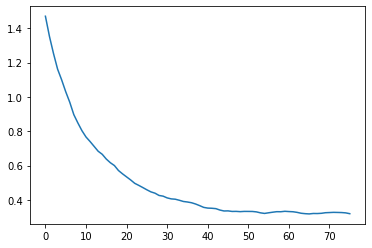

In [26]:
plt.plot(evaluation_results["valid_0"]["multi_logloss"])
model.best_score

予測値を取得してsubmission.csvを作成する

In [27]:
pred = model.predict(test_x)
# 確率をラベルにする
pred_fail = [np.argmax(p) for p in pred]

In [28]:
pred_df = pd.DataFrame(np.c_[test_df.id.unique(),pred_fail], columns=['id', 'fail_type'])

In [29]:
pred_df.head()

,id,fail_type
0,1,3
1,3,1
2,5,3
3,6,1
4,7,1


In [30]:
#結果をcsvに出力
pred_df.to_csv(filepath["submission"],index=False)

## まとめ
本サンプルでは、特徴量を自動生成するライブラリ`tsfresh`を紹介しました。初めてデータ分析に取り組まれる方は、まずはtsfreshで用意されている特徴量を使って学習し、ベースラインモデルを作ったり、特徴量の当たりをつけるといったことから初めてみるのも良いのかもしれません。